In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import train_test_split

In [66]:
def clean_data(filepath):
    data = pd.read_csv(filepath)
    
    #converting the disposable income to a standard format
    mapping = {
    'Less than 1000': 800,
    '1000 - 2000': 1600,
    '2000 - 3000': 2500,
    'More than 3000': 4000
    }
    mapping2 = {
         'Less than 1000': 800,
        '1000-2000': 1600,
        '2000-3000': 2500,
        'More than 3000': 4000
     }

    data['income'] = data['Disposable Income/Allowance'].map(mapping)
    data['income'] = data['Disposable Income/Allowance'].map(mapping2)
        
    #create our target column using Do you have any Life or Non-Life Insurance Policy column
    target_mapping = {
    'Yes': 1,
    'No': 0}    

    data['target'] = data['Do you have any Life or Non-Life Insurance Policy'].map(target_mapping)
    
    data['target'] = data['target'].fillna(0)
    
    data['target'] = data['target'].astype(int)
    
    # remove unimportant columns from the dataset
    leaky_cols = ['Timestamp','Username','Gender','Disposable Income/Allowance','Do you have any Life or Non-Life Insurance Policy']
    
    data = data.drop(columns = leaky_cols)
    data = data.dropna()
    return data

In [67]:
data = clean_data('data.csv/ip_data.csv')

In [68]:
data['income'].info()

<class 'pandas.core.series.Series'>
Int64Index: 215 entries, 0 to 256
Series name: income
Non-Null Count  Dtype  
--------------  -----  
215 non-null    float64
dtypes: float64(1)
memory usage: 3.4 KB


In [ ]:
data['Occupational Status']

In [ ]:
# Create boxplot
sns.boxplot(x = "target", y = "income", data = data)
# Label axes
plt.xlabel("Choice of Insurance")
plt.ylabel("Income Level")
plt.title("Distribution of Insurance by Income");

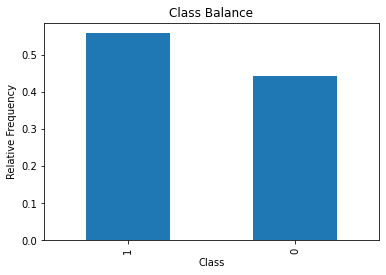

In [69]:
#class balance
data['target'].value_counts(normalize = True).plot(kind = "bar", xlabel = "Class", ylabel = "Relative Frequency", title = "Class Balance");

In [ ]:
# pivot table for Occupational Status
occupation_pivot = pd.pivot_table(data,index="Occupational Status",values = "target",aggfunc=np.mean).sort_values(by = "target")
occupation_pivot

In [70]:
y = data['target']

In [71]:
X = data.drop(columns = 'target')

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (172, 10)
y_train shape: (172,)
X_test shape: (43, 10)
y_test shape: (43,)


In [73]:
y_train.value_counts(normalize = True).max()

0.5174418604651163

In [74]:
# baseline model
acc_baseline = y_train.value_counts(normalize = True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.52


In [75]:
# Build model
model = make_pipeline(OneHotEncoder(use_cat_names = True),LogisticRegression(max_iter = 1000))
# Fit model to training data
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Educational Background',
                                     'Occupational Status', 'Educational Level',
                                     'Statutory Requirements',
                                     'Personal Benefits',
                                     'Technological Advancement',
                                     'Religious Beliefs / Affiliations',
                                     'What is your past or current experience '
                                     'with insurance companies.',
                                     'Did this experience influence your '
                                     'perception and/or decision to buy '
                                     'insurance policies.'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [76]:
#evaluation 
model.score(X_test, y_test)

0.7674418604651163

In [77]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.85
Test Accuracy: 0.77


In [78]:
#prediction probability
print(model.predict(X_train)[:5])

y_train_pred_proba = model.predict_proba(X_train)
print(y_train_pred_proba[:5])

[0 0 0 1 0]
[[0.88524168 0.11475832]
 [0.7747635  0.2252365 ]
 [0.90684679 0.09315321]
 [0.10441587 0.89558413]
 [0.56030974 0.43969026]]


In [79]:
# features that contributed to the model building
features = model.named_steps['onehotencoder'].get_feature_names_out()
importances = model.named_steps['logisticregression'].coef_[0]

# odds ratio
odds_ratios = pd.Series(np.exp(importances), index = features).sort_values()
odds_ratios.head()

Occupational Status_Student                                              0.281825
Personal Benefits_No                                                     0.466726
Religious Beliefs / Affiliations_No                                      0.537860
What is your past or current experience with insurance companies._Bad    0.601440
Technological Advancement_No                                             0.605611
dtype: float64

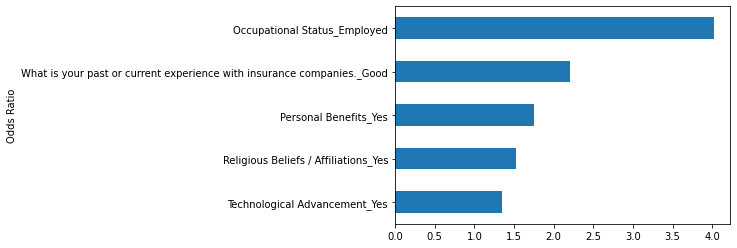

In [80]:
# Horizontal bar chart, five largest coefficients
odds_ratios.tail().plot(kind = "barh", xlabel = "Odds Ratio");

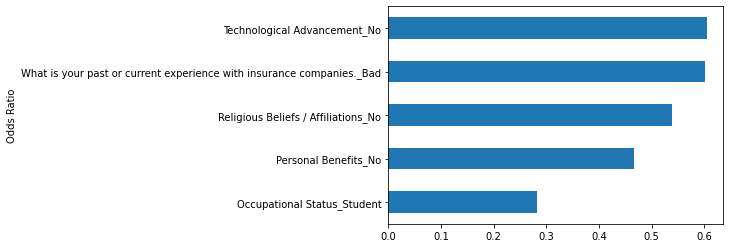

In [81]:
# Horizontal bar chart, five smallest coefficients
odds_ratios.head().plot(kind = "barh", xlabel = "Odds Ratio");